In [42]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.11.4"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.11"):
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.24.4", 'matplotlib': "3.7.2",'sklearn': "1.3.0", 
                'pandas': "2.0.3",'xgboost': "1.7.6", 'shap': "0.42.1", 'seaborn': "0.12.2"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.11.4

[ OK ] numpy version 1.24.4 is installed.
[ OK ] matplotlib version 3.7.2 is installed.
[ OK ] sklearn version 1.3.0 is installed.
[ OK ] pandas version 2.0.3 is installed.
[ OK ] xgboost version 1.7.6 is installed.
[ OK ] shap version 0.42.1 is installed.
[ OK ] seaborn version 0.12.2 is installed.


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [43]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

df = pd.read_csv('./data/hypothyroid.csv')
df.head()

print('The dataset contains', df.shape[0], 'entries')
print('Each entry has', df.shape[1], 'attributes')
print(df.dtypes)
print(df['binaryClass'].describe())
print(df['binaryClass'].value_counts().head(10))

The dataset contains 3622 entries
Each entry has 28 attributes
age                          float64
sex                           object
on thyroxine                  object
query on thyroxine            object
on antithyroid medication     object
sick                          object
pregnant                      object
thyroid surgery               object
I131 treatment                object
query hypothyroid             object
query hyperthyroid            object
lithium                       object
goitre                        object
tumor                         object
hypopituitary                 object
psych                         object
TSH measured                  object
TSH                          float64
T3 measured                   object
T3                           float64
TT4 measured                  object
TT4                          float64
T4U measured                  object
T4U                          float64
FTI measured                  object
FTI         

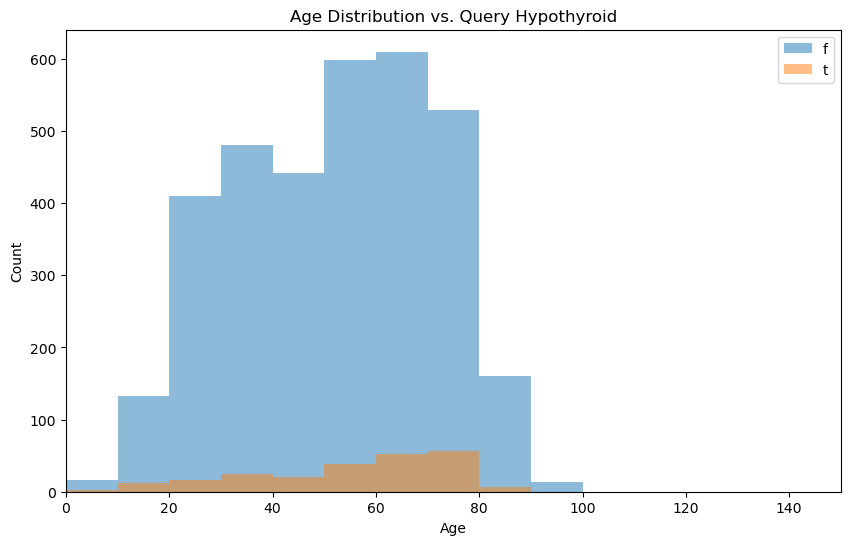

In [52]:
import matplotlib.pyplot as plt

categories = df['query hypothyroid'].unique()

plt.figure(figsize=(10, 6))
for c in categories:
    plt.hist(df[df['query hypothyroid'] == c]['age'], alpha=0.5, label=c, range=(0, 150), bins=15)
plt.legend()
plt.ylabel('Count')
plt.xlabel('Age')
plt.title('Age Distribution vs. Query Hypothyroid')
plt.xlim(0, 150)
plt.show()


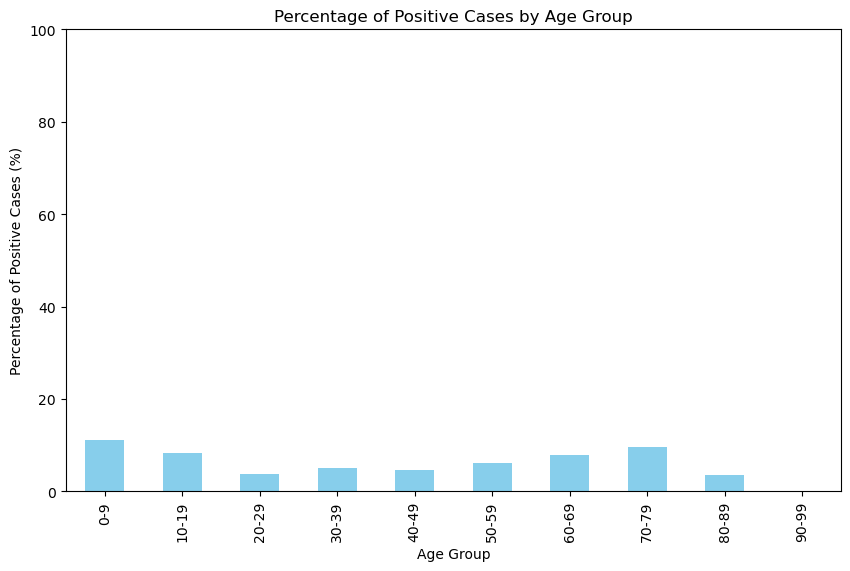

In [45]:
import matplotlib.pyplot as plt

df['age_group'] = pd.cut(df['age'], bins=range(0, 101, 10), right=False, labels=[
    '0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99'
])
age_group_totals = df['age_group'].value_counts()
age_group_positives = df[df['query hypothyroid'] == 't']['age_group'].value_counts()
positive_percentage = (age_group_positives / age_group_totals) * 100

plt.figure(figsize=(10, 6))
positive_percentage.sort_index().plot(kind='bar', color='skyblue')
plt.xlabel('Age Group')
plt.ylabel('Percentage of Positive Cases (%)')
plt.title('Percentage of Positive Cases by Age Group')
plt.ylim(0, 100)
plt.show()


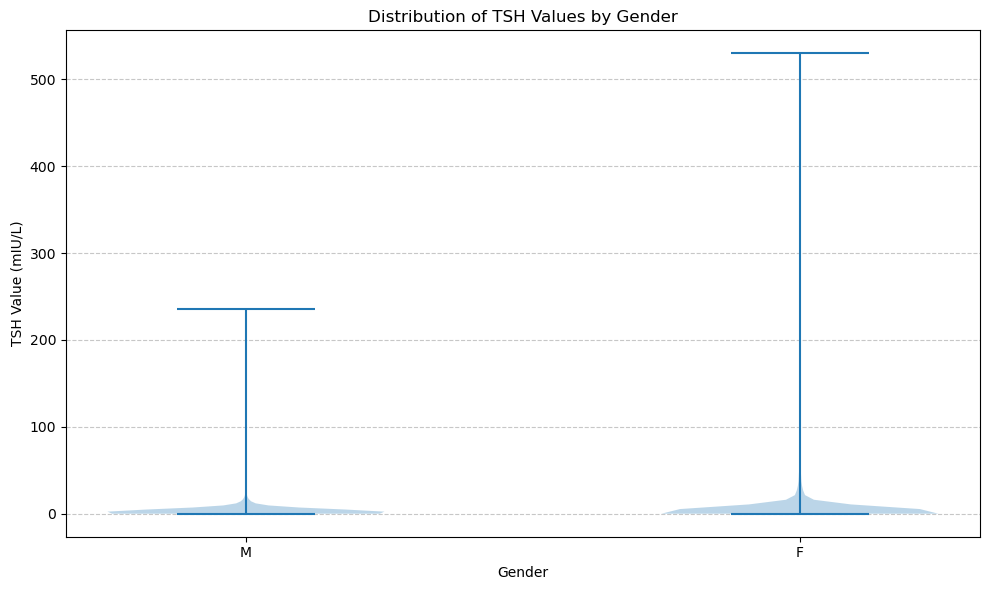

In [46]:
import matplotlib.pyplot as plt

male_tsh = df[df['sex'] == 'M']['TSH'].astype(float).dropna()
female_tsh = df[df['sex'] == 'F']['TSH'].astype(float).dropna()

plt.figure(figsize=(10, 6))
plt.violinplot([male_tsh, female_tsh], showmedians=False, showextrema=True)

plt.xticks([1, 2], ['M', 'F'])
plt.title('Distribution of TSH Values by Gender')
plt.ylabel('TSH Value (mIU/L)')
plt.xlabel('Gender')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<Figure size 1200x800 with 0 Axes>

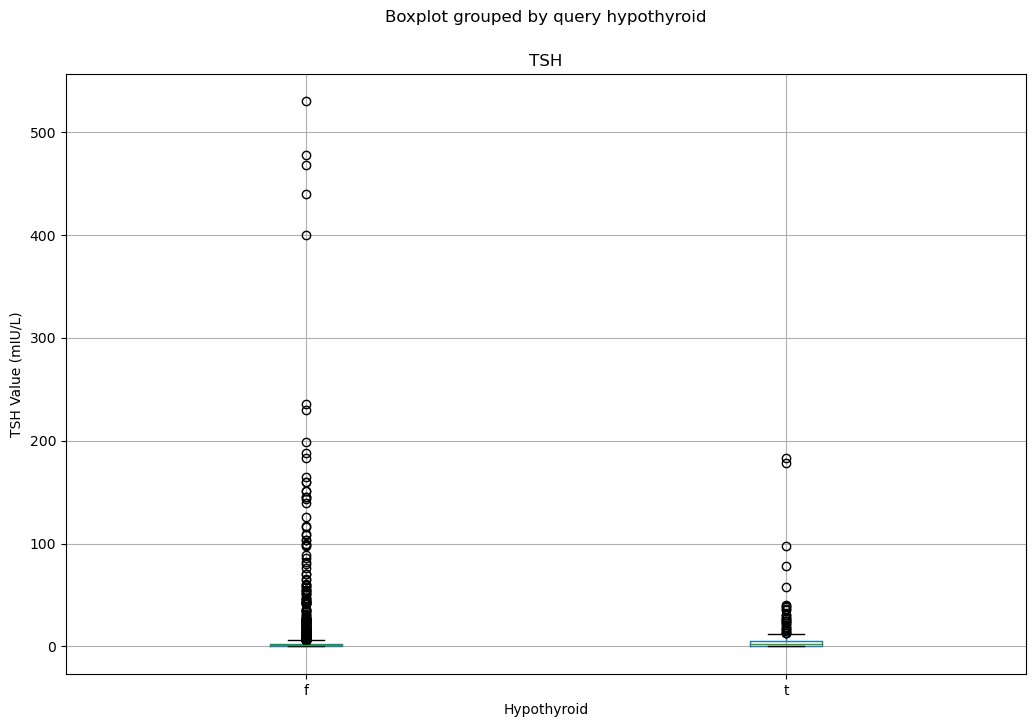

In [47]:
plt.figure(figsize=(12, 8)) 

df[['TSH','query hypothyroid']].boxplot(by='query hypothyroid', figsize=(12, 8))

plt.ylabel('TSH Value (mIU/L)')
plt.xlabel('Hypothyroid')

plt.show()


In [48]:

missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_percentage.sort_values(ascending=False, inplace=True)
print(missing_percentage)


T3                           20.568747
T4U                          10.132523
FTI                          10.077305
TSH                           9.718388
TT4                           5.991165
age_group                     0.055218
age                           0.027609
thyroid surgery               0.000000
I131 treatment                0.000000
binaryClass                   0.000000
TBG measured                  0.000000
on thyroxine                  0.000000
FTI measured                  0.000000
query on thyroxine            0.000000
T4U measured                  0.000000
on antithyroid medication     0.000000
TT4 measured                  0.000000
sick                          0.000000
T3 measured                   0.000000
pregnant                      0.000000
TSH measured                  0.000000
psych                         0.000000
sex                           0.000000
tumor                         0.000000
goitre                        0.000000
lithium                  

In [49]:

df.fillna(value=np.nan, inplace=True)


In [50]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['query hypothyroid']) 
y = df['query hypothyroid']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Testing set size:", len(X_test))


Training set size: 2173
Validation set size: 724
Testing set size: 725


In [51]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


num_ftrs = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']
cat_ftrs = X_standard.columns.difference(num_ftrs)

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_ftrs),
        ('std', StandardScaler(), num_ftrs)])

X_prep = preprocessor.fit_transform(X_train)

feature_names = preprocessor.get_feature_names_out()

Standardised_X_train = pd.DataFrame(data=X_prep, columns=feature_names)
print(Standardised_X_train.shape)

Standardised_X_val = pd.DataFrame(data=preprocessor.transform(X_val), columns=feature_names)
print(Standardised_X_val.shape)

Standardised_X_test = pd.DataFrame(data=preprocessor.transform(X_test), columns=feature_names)
print(Standardised_X_test.shape)


(2173, 47)
(724, 47)
(725, 47)


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
